In [13]:
import coco_text
import csv
import skimage.io as io
import matplotlib.pyplot as plt
import cv2


In [14]:
ct = coco_text.COCO_Text('cocotext.v2.json')

loading annotations into memory...
0:00:01.919276
creating index...
index created!


In [15]:
imgs = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])

anns = ct.getAnnIds(imgIds=ct.val, 
                        catIds=[('legibility','legible'),('class','machine printed') ], 
                        areaRng=[0,200])                   

In [16]:
dataDir='D:\School\Project\Ocr\MSCOCO dataset'
dataType='train2014'

In [17]:
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])

In [18]:
img_fms = []
for i in range(0,len(imgIds)):
    img = ct.loadImgs(imgIds[i])[0]
    img_fms.append('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))

In [19]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import json
import os
from PIL import Image


In [20]:
def fix_bbox(bbox):
    left, upper, right, lower = bbox
    # Swap left and right if left is greater than right
    if left > right:
        left, right = right, left
    # Swap upper and lower if upper is greater than lower
    if upper > lower:
        upper, lower = lower, upper
    return left, upper, right, lower

In [21]:
def remove_spaces_and_capitalize(string):
    # Remove spaces
    string_without_spaces = string.replace(" ", "")
    # Capitalize the string
    capitalized_string = string_without_spaces.capitalize()
    final_word = ''
    for i in capitalized_string:
        if i.isalpha() or i.isdigit():
            final_word += i
    return final_word

In [22]:
def crop_image(image_path, bbox, output_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    dst = cv2.Canny(gray, 0, 150)
    blured = cv2.blur(dst, (5,5), 0)    
    MIN_CONTOUR_AREA=200
    img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    Contours,imgContours = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in Contours:
        if cv2.contourArea(contour) > MIN_CONTOUR_AREA:
            [X, Y, W, H] = cv2.boundingRect(contour)
            box=cv2.rectangle(img, (X, Y), (X + W, Y + H), (0,0,255), 2)

    cropped_image = img[X:W, Y:H]
    cv2.imwrite(output_path, cropped_image)

In [23]:
def crop_bbox(image_path, bbox, output_path):
    # Open the image
    #img = Image.open(image_path)
    img = cv2.imread(image_path)

    # Crop the image using the bbox coordinates
    #cropped_img = img.crop(bbox)
    X, Y, W, H = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    x2, y2 = X + W, Y + H
    cropped_img = img[Y:y2, X:x2]

    # Get the file extension from the output path
    _, ext = os.path.splitext(output_path)
    ext = ext.lower()  # Convert extension to lowercase for consistency

    # Get the file extension from the output name
    ext = os.path.splitext(output_path)[-1].lower()

    # Map file extensions to image formats
    EXTENSION = {".jpg": "JPEG", ".jpeg": "JPEG", ".png": "PNG", ".gif": "GIF"}

    # Check if the file extension is supported
    if ext not in EXTENSION:
        raise ValueError(f"Unsupported file extension: {ext}")

    try: 
        # Save the cropped image with the specified name and format
        #cropped_img.save(output_path, format=EXTENSION[ext])
        cv2.imwrite(output_path, cropped_img)



        # Save the cropped image with the specified name
        #cropped_img.save(output_path)
    except: pass

In [24]:
for i in range(0, len(imgIds)-1):
    img = ct.loadImgs(imgIds[i])[0]
    annIds = ct.getAnnIds(imgIds=img['id'])
    anns = ct.loadAnns(annIds)
    for j in range(0, len(anns)):
        I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
        bboxpass = anns[j]['bbox']
        stringpass = anns[j]['utf8_string']
        stringpass = remove_spaces_and_capitalize(stringpass)

        if stringpass == '' :
            continue
        print(img['id'],':', stringpass, bboxpass)
        #bboxpass_1 = fix_bbox(bboxpass)
        outputpath = os.getcwd() + fr"\images\{stringpass}.jpg"
        #crop_bbox(image_path='%s/images/%s/%s'%(dataDir,dataType,img['file_name']), bbox=bboxpass, output_path=outputpath)
        file_path = f'D:/School/Project/oCR/MSCOCO dataset/images/train2014/COCO_train2014_000000{img["id"]}.jpg'
        if not os.path.exists(file_path): continue
        crop_bbox(image_path=file_path, bbox=bboxpass, output_path=outputpath)

196610 : P [152.1, 137.9, 21.6, 32.0]
196610 : 6 [292.3, 135.9, 18.4, 15.4]
294914 : 168 [406.9, 161.1, 12.5, 10.0]
294914 : 404 [306.5, 263.3, 14.4, 27.4]
294914 : United [425.4, 274.4, 52.9, 16.3]
458756 : 06 [474.2, 408.3, 26.3, 21.1]
458756 : 01 [506.9, 410.2, 24.3, 19.2]
458756 : 2009 [540.8, 408.3, 50.6, 19.2]
458756 : Chiquita [281.6, 257.3, 16.0, 27.5]
491526 : Patcham [350.3, 191.5, 35.8, 13.6]
491526 : 5 [397.2, 193.1, 8.1, 13.9]
491526 : 5 [209.9, 220.2, 4.0, 13.0]
32778 : Bryanelkuscom [164.8, 477.4, 159.1, 13.4]
458762 : Photography [21.3, 407.8, 69.3, 4.6]
458762 : Paulina [6.2, 385.0, 77.7, 27.9]
458762 : T [83.0, 386.7, 20.9, 27.1]
32787 : Ja8985 [296.3, 398.8, 33.7, 53.1]
458772 : Copytrade [73.5, 130.6, 10.3, 74.9]
524311 : Kh [354.6, 279.8, 25.5, 20.4]
393241 : 8 [272.4, 261.6, 5.5, 6.8]
524314 : Automatique [49.2, 2.6, 160.3, 23.9]
524314 : 388 [170.9, 216.4, 16.7, 9.5]
65562 : Arai [139.9, 193.7, 57.8, 23.7]
65562 : 25 [147.5, 217.4, 49.4, 43.9]
360473 : I [336.5, 

KeyboardInterrupt: 

In [ ]:
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))

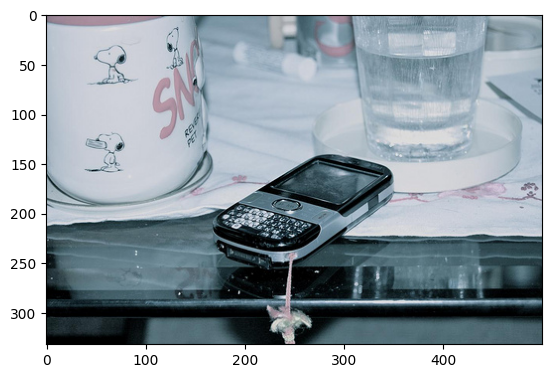

In [ ]:
plt.figure()
plt.imshow(I)